In [133]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import copy,os
import pickle
from datetime import timedelta

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

## Experiment part 1: End to end V.S. two-stage model (MQRNN)

In [93]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)
df_sl['SKU'], df_sl['DC'] = df_sl.index.str.split('#', 1).str

In [194]:
START_DAY = dt.datetime(2018,7,27)

#Benchmark2 qunatile prediction: quantiles = [0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
with open('pred_E2E_SF_RNN.pkl', 'rb') as fp: 
    bc2 = pickle.load(fp)

#Item_sku_id, sku_id, create_tm, complete_dt, vlt_actual, E2E_MLP_pred, E2E_NN_SF_mean_pred, E2E_NN_vlt_pred 
df_orders = pd.read_csv('pred_v5.csv', parse_dates=['create_tm','complete_dt','next_complete_dt'])

df_orders.head()

,item_sku_id,sku_id,create_tm,complete_dt,vlt_actual,E2E_MLP_pred,E2E_RNN_pred,E2E_NN_SF_mean_pred,E2E_NN_vlt_pred,review_period,next_complete_dt,initial_stock,mean_112
0,258214#3,258214,2018-07-30 04:50:00,2018-08-04 16:34:00,5.488264,1485.4271,2268.90280,557.55210,6.363373,1.417975,2018-08-04 16:27:00,915,194.151786
1,258214#3,258214,2018-07-31 14:52:00,2018-08-04 16:27:00,4.066100,2276.1375,2564.64800,638.37350,6.138837,7.062083,2018-08-14 15:46:00,793,193.794643
2,258214#3,258214,2018-08-07 16:22:00,2018-08-14 15:46:00,6.975035,1735.7422,2101.61990,728.61250,5.566259,5.543704,2018-08-18 14:39:00,2701,185.214286
3,258214#3,258214,2018-08-13 05:25:00,2018-08-18 14:39:00,5.384803,2011.5070,2473.88350,711.59010,6.034840,6.987188,2018-08-25 14:41:00,1795,178.392857
4,258214#4,258214,2018-07-30 04:50:00,2018-08-08 23:09:00,9.763206,500.8687,334.82117,118.85773,9.574233,7.017778,2018-08-15 23:17:00,163,27.946429


In [195]:
o4 = df_orders.copy()

In [196]:
o4['demand_RV_list'] = o4.apply(lambda x: df_sl.loc[x['item_sku_id'], \
                                            x['create_tm'].date():x['next_complete_dt'].date()].values\
                            if x['item_sku_id'] in df_sl.index else [], axis=1)

o4['demand_RV_list_acm'] = o4['demand_RV_list'].apply(lambda x: np.cumsum(x))

In [197]:
def get_inv(x, name):
    inv1, inv2 = [], []
 
    for t in range(len(x['demand_RV_list_acm'])):
        if t < np.ceil(x['vlt_actual']):
            inv1.append(x['initial_stock']-x['demand_RV_list_acm'][t])
            continue
        else:
#             if inv[-1] <= 0:
#                 inv.append(-x['demand_RV_list'][t])
#             else:
#                 inv.append(inv[-1] - x['demand_RV_list'][t])
            inv_ = x[name]+x['initial_stock']-x['demand_RV_list_acm'][t]
            inv1.append(inv_)
            inv2.append(inv_)
    return [inv1, inv2]

def get_agginv(x, name):
    inv1, inv2 = [x['initial_stock'][0]], []
    rd = len(x['sku_id'])
 
    for r in range(rd):
        if r < rd - 1:
            len_day = len(x['demand_RV_list'][r])-1
        else:
            len_day = len(x['demand_RV_list'][r])
        for t in range(len_day):
            if t == 0:
                if r == 0:
                    replen = int(round(x[name+'_pred'][r] - inv1[0]))
                else:
                    try:
                        replen = int(round(x[name+'_pred'][r] - max(inv1[-int(round(x['vlt_actual'][r]))-1], 0)))
                    except:
                        replen = int(round(x[name+'_pred'][r] - max(inv1[1],0)))
            if t < int(round(x['vlt_actual'][r])):
                if r == 0:
                    inv1.append(inv1[-1] - x['demand_RV_list'][r][t])
            elif t == int(round(x['vlt_actual'][r])):
                if inv1[-1] >= 0:
                    inv_ = inv1[-1] + replen - x['demand_RV_list'][r][t]
                else:
                    inv_ = replen - x['demand_RV_list'][r][t]
                inv1.append(inv_)
                inv2.append(inv_)
            else:
                inv_ = inv1[-1] - x['demand_RV_list'][r][t]
                inv1.append(inv_)
                inv2.append(inv_)
    
    inv1 = inv1[1:]
    return [inv1, inv2]


In [198]:
o4['E2E_MLP_replen'] = (o4['E2E_MLP_pred'] - o4['initial_stock']).clip(0)
o4['E2E_MLP_inv_f'], o4['E2E_MLP_inv'] = zip(*o4.apply(get_inv, name='E2E_MLP_replen', axis=1))

o4['E2E_RNN_replen'] = (o4['E2E_RNN_pred'] - o4['initial_stock']).clip(0)
o4['E2E_RNN_inv_f'], o4['E2E_RNN_inv'] = zip(*o4.apply(get_inv, name='E2E_RNN_replen', axis=1))

In [224]:
o4['Bm1_pred'] = np.mean(bc2[:,:,3], axis=1)
o4['Bm1_pred'] = o4['Bm1_pred'] * (np.ceil(o4['review_period']) + np.ceil(o4['E2E_NN_vlt_pred']))

def get_bm2(x):
    rl = np.ceil(x['review_period']) + np.ceil(x['E2E_NN_vlt_pred'])
    if rl <= b:
        days = int(rl)
    else:
        days = int(rl) - rl//(b+h)
    return x['Bm2_pred'] * days

o4['Bm2_pred'] = np.mean(bc2[:,:,4], axis=1)
o4['Bm2_pred'] = o4.apply(get_bm2, axis=1)

o4['Bm1_replen'] = (o4['Bm1_pred'] - o4['initial_stock']).clip(0)
o4['Bm1_inv_f'], o4['Bm1_inv'] = zip(*o4.apply(get_inv, name='Bm1_replen', axis=1))
o4['Bm2_replen'] = (o4['Bm2_pred'] - o4['initial_stock']).clip(0)
o4['Bm2_inv_f'], o4['Bm2_inv'] = zip(*o4.apply(get_inv, name='Bm2_replen', axis=1))

In [225]:
o4g = o4.groupby('item_sku_id').agg(lambda x: x.tolist())

In [226]:
o4g['E2E_MLP_agginv_f'], o4g['E2E_MLP_agginv'] = zip(*o4g.apply(get_agginv, name='E2E_MLP',  axis=1))
o4g['E2E_RNN_agginv_f'], o4g['E2E_RNN_agginv'] = zip(*o4g.apply(get_agginv, name='E2E_RNN',  axis=1))
o4g['Bm1_agginv_f'], o4g['Bm1_agginv'] = zip(*o4g.apply(get_agginv, name='Bm1',  axis=1))
o4g['Bm2_agginv_f'], o4g['Bm2_agginv'] = zip(*o4g.apply(get_agginv, name='Bm2',  axis=1))

In [227]:
list_c2 = ['SKU_DC',
          'E2E_MLP', 'E2E_RNN',
          'Bm1','Bm2',  
          'Ave_sales'
         ]
numberOfRows = len(o4g)
df2_cost_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_holding_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_back_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_stockout_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)
df2_turnover_agg = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c2)

df2_cost_agg['SKU_DC']=df2_holding_agg['SKU_DC']=df2_back_agg['SKU_DC']=df2_stockout_agg['SKU_DC']\
            =df2_turnover_agg['SKU_DC']=o4g.index.values
df2_cost_agg['Ave_sales']=df2_holding_agg['Ave_sales']=df2_back_agg['Ave_sales']=df2_stockout_agg['Ave_sales']\
            =df2_turnover_agg['Ave_sales']=o4g['mean_112'].apply(lambda x:x[0]).values

In [228]:
o4g_ = o4g.reset_index(drop=True)
for str1 in str_list2:
    str2 = str1 + '_agginv'
    df2_holding_agg[str1] = o4g_[str2].apply(lambda x: h * sum([inv for inv in x if inv>0]) )
    df2_back_agg[str1] = o4g_[str2].apply(lambda x: b * -sum([inv for inv in x if inv<0]) )
    df2_stockout_agg[str1] = o4g_[str2].apply(lambda x: len([inv for inv in x if inv<0])/len(x) if len(x)>0 else 0 )
    df2_turnover_agg[str1] = o4g_.apply(lambda x: np.mean([max(i,0) for i in x[str2]]) / x['mean_112'][0]
                                  if np.mean(x['mean_112'][0]) >0 else np.mean(x[str2]), axis=1).fillna(7)
    df2_cost_agg[str1] = df2_holding_agg[str1] + df2_back_agg[str1]

In [229]:
df2_aggcom = pd.DataFrame({'Total cost': df2_cost_agg[str_list2].mean(),
             'Holding cost': df2_holding_agg[str_list2].mean(),
             'Stockout cost': df2_back_agg[str_list2].mean(),
             'Stockout rate': df2_stockout_agg[str_list2].mean(),
             'Turnover rate': df2_turnover_agg[str_list2].mean(),
             }).T
df2_aggcom

,E2E_MLP,E2E_RNN,Bm1,Bm2
Total cost,3470.049790,3569.387522,3567.116977,3515.200960
Holding cost,1991.296341,1904.981404,1710.023395,1924.284943
Stockout cost,1478.753449,1664.406119,1857.093581,1590.916017
Stockout rate,0.096356,0.106856,0.149746,0.099476
Turnover rate,10.705349,13.333803,8.058215,10.336719


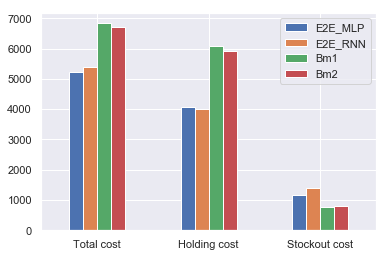

In [20]:
df_com.iloc[0:3,:].plot.bar(rot=0)
plt.savefig('../figures/eps/exp1.eps', dpi=200)

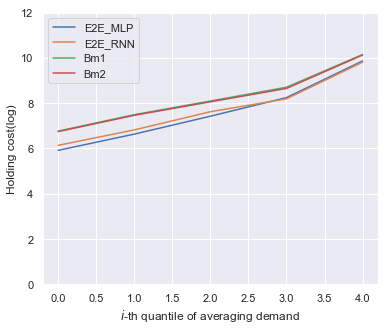

In [42]:
sl_qtl = df_holding.iloc[:,2:].sort_values('Ave_sales').groupby(df_cost.index//360).mean()
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.log(sl_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(sl_qtl.columns[:-2], loc=0)
ax.set_xlabel('$i$-th quantile of averaging demand');
ax.set_ylabel('Holding cost(log)');
ax.set_ylim((0,12));
# plt.savefig('../figures/eps/qtl2.eps', dpi=200)